In [1]:
import os
import glob
from datetime import datetime

import pandas as pd
import pandas_profiling as pdprof
import numpy as np
from decimal import Decimal
import collections
import time
# import utm

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure

%matplotlib inline
import seaborn as sns
# sns.set_theme()
sns.set_style()


import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from brokenaxes import brokenaxes

from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from functools import reduce

In [2]:
OPS_fleet = pd.read_excel("Ship Results (1).xlsx")

In [8]:
OPS_fleet.head()

,IMO/LR/IHS No.,Name of Ship,Class,Total KW Main Eng,Aux. Engine Total KW,Ship Type,Fuel Consumption Main Engines,Fuel Type 1,Fuel Type 2,GT,Deadweight,Operator
0,9102992,AEGEAN MAJESTY,LR,33924,970.0,Passenger/Cruise,0.0,Distillate Fuel,Residual Fuel,57092,6604,Optimum Shipmanagement Service
1,9732345,AFIF,VL,54900,4320.0,Container Ship (Fully Cellular),218.0,Distillate Fuel,Residual Fuel,153148,149360,Hapag-Lloyd AG
2,9315381,AGAMEMNON,BV,68640,3300.0,Container Ship (Fully Cellular),264.0,Distillate Fuel,Residual Fuel,89776,103772,MSC Mediterranean Shipping Co
3,9362542,AIDABELLA,VL,36776,NaN,Passenger/Cruise,0.0,Distillate Fuel,Residual Fuel,69203,8765,Aida Cruises
4,9398888,AIDABLU,VL,36000,NaN,Passenger/Cruise,0.0,Distillate Fuel,Residual Fuel,71304,7889,Aida Cruises


In [3]:
OPS_fleet.describe(include='all')

,IMO/LR/IHS No.,Name of Ship,Class,Total KW Main Eng,Aux. Engine Total KW,Ship Type,Fuel Consumption Main Engines,Fuel Type 1,Fuel Type 2,GT,Deadweight,Operator
count,6.470000e+02,647,637,647.000000,491.000000,647,647.000000,647,647,647.000000,647.000000,647
unique,NaN,647,22,NaN,NaN,14,NaN,7,4,NaN,NaN,95
top,NaN,SILJA SYMPHONY,VL,NaN,NaN,Container Ship (Fully Cellular),NaN,Distillate Fuel,Residual Fuel,NaN,NaN,Evergreen Marine Corp
freq,NaN,1,207,NaN,NaN,500,NaN,622,602,NaN,NaN,75
mean,9.453941e+06,NaN,NaN,48821.106646,2893.228106,NaN,142.557388,NaN,NaN,87649.217929,85581.332303,NaN
std,3.087217e+05,NaN,NaN,19421.559146,1260.216166,NaN,99.569368,NaN,NaN,49119.229038,67127.819281,NaN
min,7.428433e+06,NaN,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,193.000000,32.000000,NaN
25%,9.302639e+06,NaN,NaN,35730.000000,1800.000000,NaN,0.000000,NaN,NaN,47952.000000,36972.000000,NaN
50%,9.450583e+06,NaN,NaN,53000.000000,3060.000000,NaN,175.000000,NaN,NaN,89787.000000,80855.000000,NaN
75%,9.645919e+06,NaN,NaN,64200.000000,3840.000000,NaN,226.600000,NaN,NaN,113042.000000,115031.000000,NaN


In [19]:
# OPS fleet by ship type

print('Number of ships ready for OPS =  ' + str(len(OPS_fleet)))
print('')
for each in OPS_fleet['Ship Type'].unique():
    print(str(each) + ' - ' + str(round(len(OPS_fleet[OPS_fleet['Ship Type']==each])*100/len(OPS_fleet),2)) + ' % (' + 
                              str(len(OPS_fleet[OPS_fleet['Ship Type']==each])) + ')')


Number of ships ready for OPS =  647

Passenger/Cruise - 8.66 % (56)
Container Ship (Fully Cellular) - 77.28 % (500)
Ro-Ro Cargo Ship - 2.63 % (17)
Chemical/Products Tanker - 0.62 % (4)
Waste Disposal Vessel - 0.31 % (2)
Passenger/Ro-Ro Ship (Vehicles) - 5.72 % (37)
Platform Supply Ship - 0.31 % (2)
Passenger Ship - 0.15 % (1)
Passenger/Ro-Ro Ship (Vehicles/Rail) - 0.93 % (6)
Anchor Handling Tug Supply - 0.46 % (3)
Container Ship (Fully Cellular/Ro-Ro Facility) - 0.46 % (3)
Vehicles Carrier - 0.46 % (3)
Ore Carrier - 1.7 % (11)
FSO, Gas - 0.31 % (2)


C:\Users\badria\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\badria\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\badria\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\badria\Ana

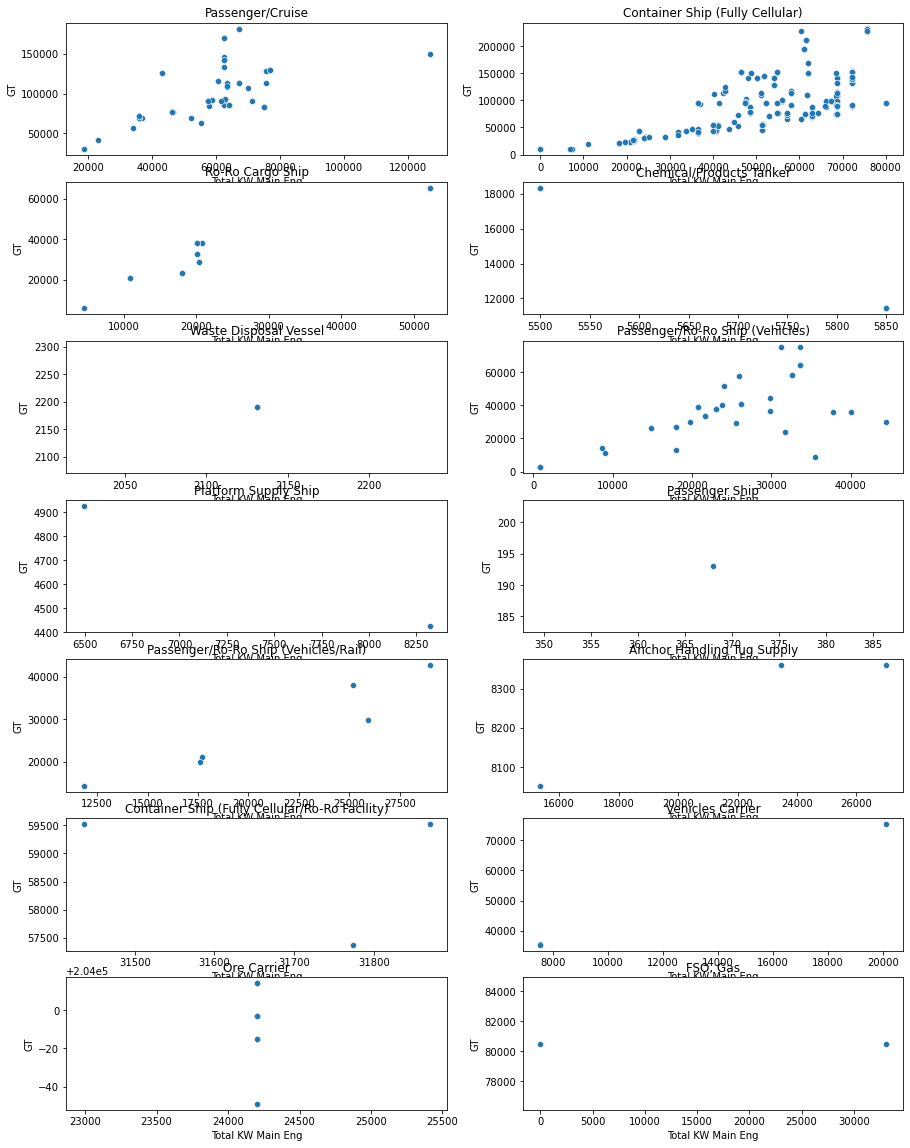

In [12]:
# GT vs Engine Power (by ship type)

count=1
plt.subplots(figsize=(15, 20))
for i in OPS_fleet['Ship Type'].unique():
    plt.subplot(7,2,count)
    sns.scatterplot(OPS_fleet['Total KW Main Eng'][OPS_fleet['Ship Type']==i],OPS_fleet['GT'][OPS_fleet['Ship Type']==i])
    plt.title(i)
    count+=1

plt.show()   

In [13]:
OPS_fleet[OPS_fleet['Ship Type']=='Ore Carrier']

,IMO/LR/IHS No.,Name of Ship,Class,Total KW Main Eng,Aux. Engine Total KW,Ship Type,Fuel Consumption Main Engines,Fuel Type 1,Fuel Type 2,GT,Deadweight,Operator
496,9807023,ORE TIANJIN,CC AB,24200,1350.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203951,399213,Hong Kong Ming Wah Shpg Co Ltd
497,9807061,PACIFIC AUSPICE,CC VL,24200,1500.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203985,397933,Vale SA
500,9806988,PACIFIC HARVEST,CC VL,24200,1345.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,204014,399999,Hong Kong Ming Wah Shpg Co Ltd
501,9807059,PACIFIC PROSPERITY,CC VL,24200,1345.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203985,398438,Vale SA
502,9806976,PACIFIC UNITY,CC VL,24200,1345.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,204014,398707,Vale SA
503,9806990,PACIFIC VISION,CC VL,24200,1500.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,204014,398411,Hong Kong Ming Wah Shpg Co Ltd
640,9806902,YUAN BAO HAI,CC VL,24200,1500.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203997,398453,Shenzhen Ocean Shipping Co Ltd
641,9806885,YUAN GU HAI,CC VL,24200,1500.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203997,398292,Shenzhen Ocean Shipping Co Ltd
642,9806873,YUAN HE HAI,VL CC,24200,1500.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203997,398595,Vale SA
643,9806952,YUAN QIAN HAI,CC VL,24200,1345.0,Ore Carrier,79.5,Distillate Fuel,Residual Fuel,203997,398151,Vale SA


In [29]:
container = OPS_fleet[OPS_fleet['Ship Type'].isin(['Container Ship (Fully Cellular)',
                                                   'Container Ship (Fully Cellular/Ro-Ro Facility)'])]
ropax_roro = OPS_fleet[OPS_fleet['Ship Type'].isin(['Ro-Ro Cargo Ship','Passenger/Ro-Ro Ship (Vehicles)',
                                                   'Passenger Ship','Passenger/Ro-Ro Ship (Vehicles/Rail)'])]
cruise = OPS_fleet[OPS_fleet['Ship Type']=='Passenger/Cruise']

In [32]:
cruise.describe()

,IMO/LR/IHS No.,Total KW Main Eng,Aux. Engine Total KW,Fuel Consumption Main Engines,GT,Deadweight
count,5.600000e+01,56.000000,33.000000,56.000000,56.000000,56.000000
mean,9.351736e+06,58654.607143,1990.484848,23.035714,100934.892857,9999.446429
std,2.108103e+05,17027.485557,2883.908558,71.335816,33200.242713,2810.199811
min,9.000259e+06,18596.000000,647.000000,0.000000,30277.000000,2700.000000
25%,9.210418e+06,46470.000000,1125.000000,0.000000,77484.500000,8230.750000
50%,9.242364e+06,62400.000000,1200.000000,0.000000,90515.000000,9200.000000
75%,9.456702e+06,67200.000000,1400.000000,0.000000,118322.500000,11806.250000
max,9.843807e+06,126860.000000,14400.000000,285.000000,181541.000000,19189.000000


C:\Users\badria\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Total KW Main Eng'>

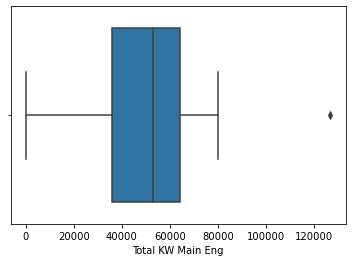

In [4]:
# Main engine power description of OPs fleet

sns.boxplot(OPS_fleet['Total KW Main Eng'])

C:\Users\badria\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='GT'>

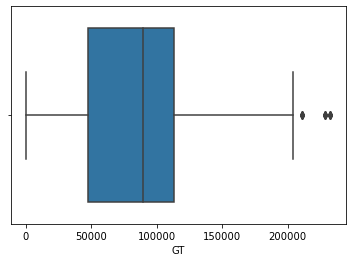

In [3]:
# GT description of OPS fleet

sns.boxplot(OPS_fleet['GT'])

In [7]:
# percentage of fleet OPS ready in the world
round(64700/61200,2)

1.06

In [6]:
# percentage of container, roro/ropax and cruise OPS-ready 
round(77.7+9.4+8.7,2)

95.8